## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

# Summary of my results

Main changes:
- calculate `elapsed_years` with respect to `YearBuilt` instead of `YrSold`
- OneHot encoding of categorical variables
- do not discretize continuous numerical variables
- used ScikitLearn instead of Feature-Engine

Results on the test set:
- rmse = 38063.04673161993
- r2 = 0.7891776453011499 



## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
# from feature_engine import missing_data_imputers as mdi
# from feature_engine import discretisers as dsc
# from feature_engine import categorical_encoders as ce

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../houseprice.csv')

In [3]:
# make lists of variable types

categorical_vars = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete_vars = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 15 and var not in year_vars
]

numerical_vars = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete_vars and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical_vars)))
print('There are {} discrete variables'.format(len(discrete_vars)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical_vars)))

There are 19 continuous variables
There are 13 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [4]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and year the house was *built*
    
    df[var] = df[var] - df['YearBuilt']
    return df

for var in ['YrSold', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)
    
# drop YrSold
X_train.drop('YearBuilt', axis=1, inplace=True)
X_test.drop('YearBuilt', axis=1, inplace=True)

# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [6]:
## functions to encode rare categories
def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count()/len(df)
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare

def rare_encoding(X_train, X_test, variable, tolerance):

    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test

## encoding rare categories
for var in categorical_vars+discrete_vars:
    X_train, X_test = rare_encoding(X_train, X_test, var, 0.05)

In [38]:
## building our pipeline using scikitlearn

numeric_transformer = Pipeline(steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot_enc', OneHotEncoder(drop='first'))])

discrete_transformer = Pipeline(steps=[
    ('imputer_disc', SimpleImputer(strategy='most_frequent')),
    ('onehot_enc', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_vars),
    ('cat', categorical_transformer, categorical_vars),
    ('disc', discrete_transformer, discrete_vars)
])

house_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('lasso', Lasso(random_state=0))])

In [39]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 684649908.3271698
train rmse: 26165.815644217357
train r2: 0.8903477989380937

test mse: 1448795526.4934826
test rmse: 38063.04673161993
test r2: 0.7891776453011499


/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9661515757.803345, tolerance: 820439508.5822281
  positive)


We see an improvement on both rmse and r2 score with respect to the baseline as desired :)

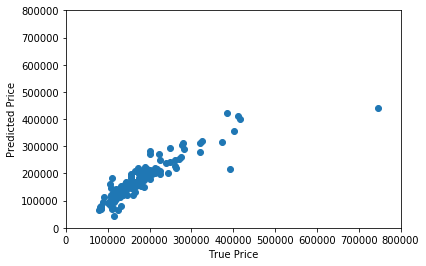

In [9]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.xlim(0,800000)
plt.ylim(0,800000);